<a href="https://colab.research.google.com/github/lit2020/class-deep-learning/blob/main/%5BDL%5Dpractice6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# practice 1. Auto Encoder

In [ ]:
#import pakckages

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from keras.datasets.fashion_mnist import load_data

import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
# GPU / CPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
random.seed(1214)
torch.manual_seed(1214)
if device == 'cuda':
    torch.cuda.manual_seed_all(1214)

cuda


In [ ]:
#dataset
fashion_train = dataset.FashionMNIST("../image_data/FashionMNIST", train=True, download=True,
                                        transform=transforms.ToTensor())
fashion_test = dataset.FashionMNIST("../image_data/FashionMNIST", train=False, download=True,
                                        transform=transforms.ToTensor())

# Normalization
fashion_train.data = fashion_train.data/255.0
fashion_train.targets = fashion_train.targets
fashion_test.data = fashion_test.data/255.0
fashion_test.targets = fashion_test.targets


tensor(0)


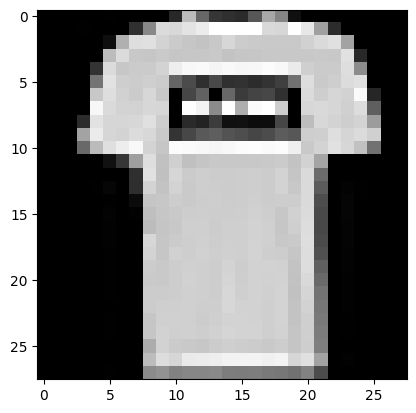

In [ ]:
plt.imshow(fashion_train.data[1], cmap='gray')
print(fashion_train.targets[1])

In [ ]:
batch_size = 256
train_loader= DataLoader(dataset=fashion_train.data, batch_size=batch_size,
                         shuffle=True, drop_last=False)

# 테스트 데이터 전체를 1배치로 지정
test_loader= DataLoader(dataset=fashion_test.data, batch_size=len(fashion_test.data),
                        shuffle=False,)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(784, 16)
        self.decoder = nn.Linear(16, 784)

    def forward(self, x):
        z_vector = self.encoder(x)
        output = self.decoder(z_vector)

        return torch.sigmoid(output)

In [ ]:
model = Autoencoder().to(device)

In [ ]:
# hyperparameters
num_epochs = 5
learning_rate = 0.003

# 오토인코더의 입력 벡터 (784,)를 z_vector (16,)으로 축소시킨 후에
# 디코딩 단계에서 (784,)로 복원함
# loss는 원래 인풋과 복원된 벡터의 차이
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train

loss_list = []
model.train()
for epoch_num in range(num_epochs):
    average_cost = 0

    for batch_idx, images in enumerate(train_loader):
        # train_loader에서 1배치 단위로 가져와서 미니배치로 사용
        num_of_mini_batch = len(train_loader)
        # (28, 28) image size
        images = images.to(device)
        # (784, )
        input_image = images.reshape(-1, 28 * 28)

        # 그라디언트 초기화
        optimizer.zero_grad()

        # (784, )
        y_predict = model(input_image)

        # 원본 이미지와 복원한 이미지의 차이로 Loss 평가
        loss_train = criterion(y_predict, input_image)
        loss_train.backward() # back prop.
        optimizer.step() # update model parameters

        average_cost = average_cost + (loss_train.item() / num_of_mini_batch)
        loss_list.append(loss_train)

    if ((epoch_num + 1) % 1 == 0):
        print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

In [ ]:
for batch_idx, image in enumerate(test_loader):
    with torch.no_grad():
        test_image = image.reshape(-1, 784).to(device)
        test_recon_x = model(test_image)

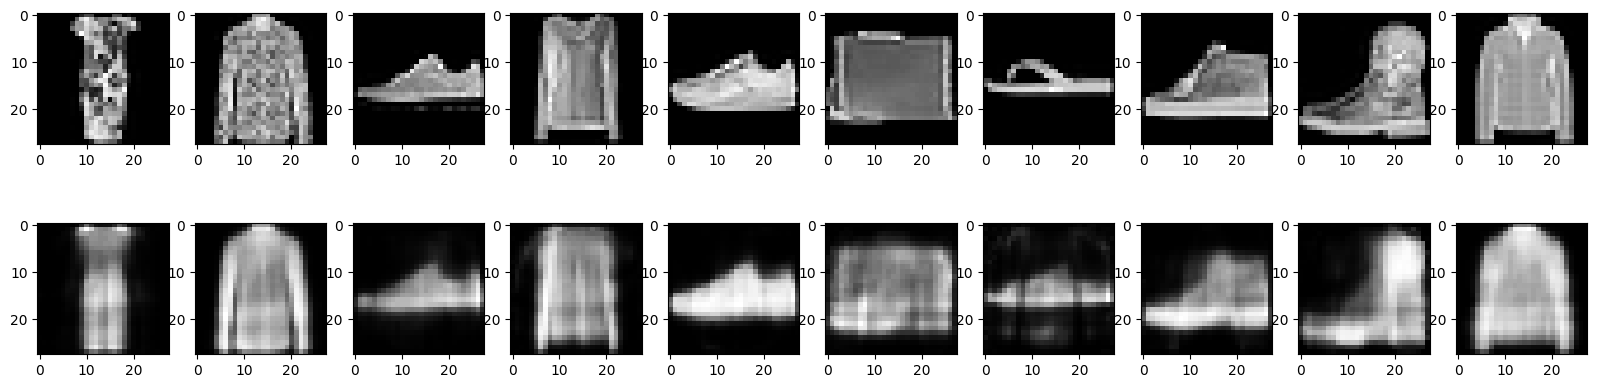

In [ ]:
n = 10
plt.figure(figsize = (20 ,5))

for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    test_image = image[i + 100].to(device)
    plt.imshow(test_image.cpu(), cmap='gray')

    ax = plt.subplot(2, 10, i + 1 + n)
    recon_image = test_recon_x.data[i + 100].reshape(28, 28)
    plt.imshow(recon_image.cpu(), cmap='gray')

In [ ]:
# practice 2. Variational AutoEncoder

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download = True,
                                            transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download = True,
                                            transform = transforms.ToTensor())


In [ ]:
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                         shuffle=True, drop_last=True)

# 테스트 데이터 전체를 1배치로 지정
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size,
                        shuffle=False)

In [ ]:
# (784) => (400) => (20) => (400) => (784)
#       : 평균, 분산 추정
class VAE(nn.Module):
    def __init__ (self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.mu = nn.Linear(400, 20) # 평균 추정
        self.logvar = nn.Linear(400, 20) # (log) variance 추정
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.mu(h1)
        logvar = self.logvar(h1)

        return mu, logvar

    def reparameterize(self, mu_vector, logvar_vector):
        #log variance -> variance
        var_vector = torch.exp(logvar_vector)
        std = torch.sqrt(var_vector)
        # std를 따르는 정규분포에서 추출한 난수
        eps = torch.randn_like(std)
        z_vector = mu_vector + eps.mul(std)

        return z_vector

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        bern = torch.sigmoid(self.fc3(h2))
        return bern

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        bern = self.decode(z)

        return bern, mu, logvar

In [ ]:
vae = VAE().to(device)

In [ ]:
# 분류 - CrossEntropy
# 회귀, AE - MSELoss

# loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    # 출력에 대한 Loss
    Bernouhlli_loss = F.binary_cross_entropy(recon_x, x.reshape(-1, 784),
                                            reduction='sum')
    #
    KL_divergence = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return Bernouhlli_loss + KL_divergence

In [ ]:
# hyperparameters
num_epochs = 5
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)


In [ ]:
# Train

loss_list = []
for epoch_num in range(num_epochs):
    average_cost = 0

    for batch_idx, (images, label) in enumerate(train_loader):
        # train_loader에서 1배치 단위로 가져와서 미니배치로 사용
        num_of_mini_batch = len(train_loader)

        images = images.to(device)
        input_image = images.reshape(-1, 28 * 28)

        # 그라디언트 초기화
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(input_image)
        # 원본 이미지와 복원한 이미지의 차이로 Loss 평가
        loss = loss_function(recon_x, input_image, mu, logvar)
        loss.backward() # back prop.
        optimizer.step() # update model parameters

        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss_train)

    if ((epoch_num + 1) % 1 == 0):
        print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 48693.64966
Epoch 2 Loss 33989.56979
Epoch 3 Loss 30929.77128
Epoch 4 Loss 29643.85647
Epoch 5 Loss 29006.97805


In [ ]:
for batch_idx, (image, label) in enumerate(test_loader):
    with torch.no_grad():
        test_image = image.to(device)
        test_image = test_image.reshape(-1, 28 * 28)
        test_recon_x, _, _ = vae(test_image)

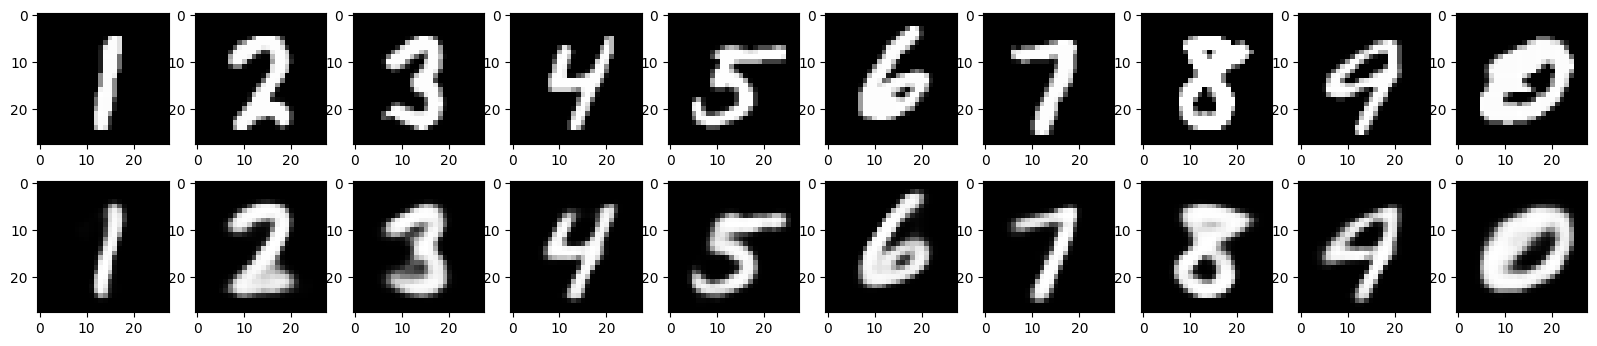

In [ ]:
n = 10
plt.figure(figsize = (20 ,4))

for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    image = test_image[i].reshape(28, 28)
    plt.imshow(image.cpu(), cmap='gray')

    ax = plt.subplot(2, 10, i + 1 + n)
    recon_image = test_recon_x.data[i].reshape(28, 28)
    plt.imshow(recon_image.cpu(), cmap='gray')

In [ ]:

# MNIST Generation

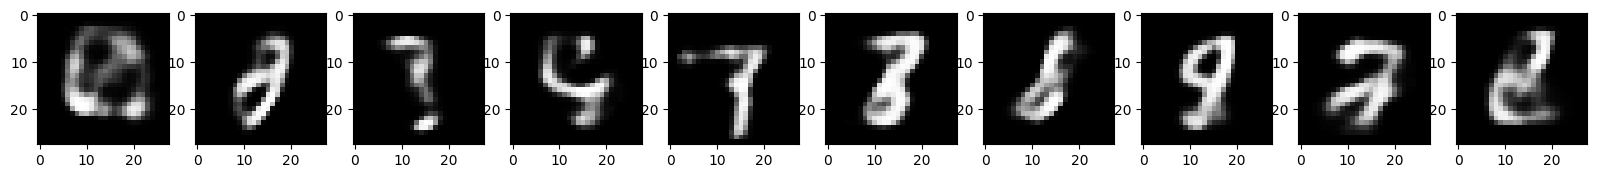

In [ ]:
plt.figure(figsize=(20,4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    with torch.no_grad():
        # 의미없는 난수 벡터
        sample_z = torch.randn(20).to(device)
        input_z = sample_z
        # VAE의 디코더 부분만 사용해서 (20, ) = > (784, ) 생성
        sample = vae.decode(input_z).cpu()
        plt.imshow(sample.reshape(28, 28), cmap='gray')
